In [1]:
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from yellowbrick.cluster import InterclusterDistance
import sklearn.cluster as skc

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\shane\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\shane\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\shane\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\shane\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
In C:\Users\shane\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\shane\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\shane\Anaconda3\lib\site-packages\matplotlib\mpl-data\st

In [2]:
class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words
        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters
 
    def learn(self):
        sift = cv.xfeatures2d.SIFT_create()
        num_keypoints = [] #this is used to store the number of keypoints in each image
        #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)
        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_
        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)
        return training_word_histograms
 
    def create_word_histograms(self, img_filenames):
        sift = cv.xfeatures2d.SIFT_create()
        histograms = []
        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image
            if descriptors is not None:
                for des in descriptors:
                    #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching
                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
                    histogram[matching_word_ID] += 1
                histogram /= len(descriptors) #normalise histogram to frequencies
            histograms.append(histogram)
        return histograms

# SECTION 2.0: BUILDING THE CLASSIFIER

## Onboarding Training Data

In [3]:
vehicles = ['planes', 'boats', 'cars', 'trains']
path = 'datasets/'
training_file_names = []
training_vehicle_labels = []
for i in range(0, len(vehicles)):
    sub_path = path + 'train/' + vehicles[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_vehicle_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_vehicle_labels += sub_vehicle_labels
training_file_names.sort()
training_vehicle_labels.sort()
num_words = 50
dictionary_name = 'vehicles'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)
training_word_histograms = dictionary.learn()

## Onboarding Validation Data

In [4]:
valid_file_names = []
valid_vehicle_labels = []
for i in range(0, len(vehicles)):
    sub_path = path + 'valid/' + vehicles[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_vehicle_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    valid_file_names += sub_file_names
    valid_vehicle_labels += sub_vehicle_labels
valid_file_names.sort()
valid_vehicle_labels.sort()
valid_word_histograms = dictionary.create_word_histograms(valid_file_names)

## Onboarding Test Data

In [5]:
test_file_names = []
test_vehicle_labels = []
for i in range(0, len(vehicles)):
    sub_path = path + 'test/' + vehicles[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_vehicle_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    test_file_names += sub_file_names
    test_vehicle_labels += sub_vehicle_labels
test_file_names.sort()
test_vehicle_labels.sort()
test_word_histograms = dictionary.create_word_histograms(test_file_names)

### K Value Estimation 1: ELBOW METHOD

Text(0, 0.5, 'Total Squared Distance')

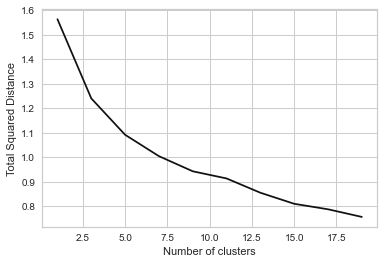

In [6]:
import matplotlib.pyplot as plt
import sklearn.cluster as skc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

totSqrdDist=[]
kRange=range(1,20,2)
for k in kRange:
    kmns=skc.KMeans(n_clusters=k)
    kmns=kmns.fit(training_word_histograms)
    totSqrdDist.append(kmns.inertia_)
    
plt.plot(kRange,totSqrdDist,'-xk')
plt.xlabel("Number of clusters")
plt.ylabel("Total Squared Distance")

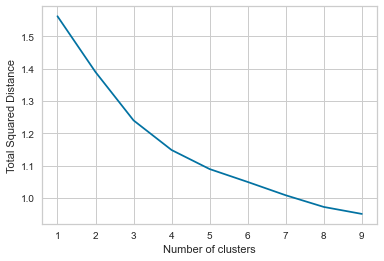

In [7]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(training_word_histograms)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances,'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Total Squared Distance")
plt.show()

### K Value Estimation 2: Silhouette METHOD

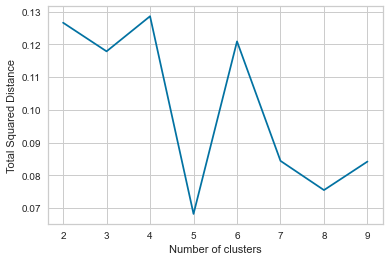

In [8]:
from sklearn.metrics import silhouette_score
silhouette_avg = []
kRange=range(2,10)

for k in kRange:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(training_word_histograms)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(training_word_histograms, cluster_labels))
    
plt.plot(kRange,silhouette_avg,'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Total Squared Distance")
plt.show()

### Intercluster Distance Maps

<bound method Visualizer.show of InterclusterDistance(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=4))>

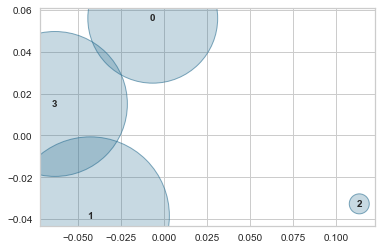

In [12]:
model = KMeans(4)
viz1 = InterclusterDistance(model)
viz1.fit(training_word_histograms)
viz1.show

# SECTION 3.0 BUILDING AND TRAINING CLASSIFIERS

## KNN HYPER TUNING ON VALIDATION 

In [13]:
print("Using KNN with various numbers of neighbours:")
for i in range (5, 35, 5):

    num_nearest_neighbours = i 
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(training_word_histograms, training_vehicle_labels)
    predicted_vehicle_labels = knn.predict(valid_word_histograms)
    cm = confusion_matrix(valid_vehicle_labels, predicted_vehicle_labels)
    acc = accuracy_score(valid_vehicle_labels, predicted_vehicle_labels)
    print("Results when k =", i)
    print("Accuracy: ", acc)
    print("Confusion matrix:")
    print(cm)
    print()

Using KNN with various numbers of neighbours:
Results when k = 5
Accuracy:  0.4666666666666667
Confusion matrix:
[[30  0  0  0]
 [11  5  3 11]
 [ 8  6 11  5]
 [16  4  0 10]]

Results when k = 10
Accuracy:  0.5166666666666667
Confusion matrix:
[[30  0  0  0]
 [ 7  9  2 12]
 [ 8  4  9  9]
 [15  1  0 14]]

Results when k = 15
Accuracy:  0.5416666666666666
Confusion matrix:
[[28  0  1  1]
 [ 8  9  3 10]
 [ 8  4 10  8]
 [11  0  1 18]]

Results when k = 20
Accuracy:  0.5083333333333333
Confusion matrix:
[[26  0  1  3]
 [10  7  3 10]
 [ 8  5  6 11]
 [ 8  0  0 22]]

Results when k = 25
Accuracy:  0.49166666666666664
Confusion matrix:
[[26  0  1  3]
 [ 4  6  3 17]
 [ 6  6  7 11]
 [10  0  0 20]]

Results when k = 30
Accuracy:  0.5166666666666667
Confusion matrix:
[[26  0  1  3]
 [ 7  7  3 13]
 [ 5  5  6 14]
 [ 7  0  0 23]]



## SVM HYPER TUNING ON VALIDATION 

In [14]:
print("Using SVM with various values of C:")
for i in range (10, 60, 10):

    svm_classifier = svm.SVC(C = i, kernel = 'linear')
    svm_classifier.fit(training_word_histograms, training_vehicle_labels)
    predicted_vehicle_labels = svm_classifier.predict(valid_word_histograms)
    cm = confusion_matrix(valid_vehicle_labels, predicted_vehicle_labels)
    acc = accuracy_score(valid_vehicle_labels, predicted_vehicle_labels)
    print("Results when C =", i)
    print("Accuracy: ", acc)
    print("Confusion matrix:")
    print(cm)
    print()

Using SVM with various values of C:
Results when C = 10
Accuracy:  0.5333333333333333
Confusion matrix:
[[22  0  2  6]
 [ 0  6  1 23]
 [ 1  7  8 14]
 [ 1  1  0 28]]

Results when C = 20
Accuracy:  0.5583333333333333
Confusion matrix:
[[23  0  2  5]
 [ 1  8  2 19]
 [ 1  8  9 12]
 [ 2  1  0 27]]

Results when C = 30
Accuracy:  0.6166666666666667
Confusion matrix:
[[25  0  2  3]
 [ 1 12  2 15]
 [ 1  7 10 12]
 [ 3  0  0 27]]

Results when C = 40
Accuracy:  0.6083333333333333
Confusion matrix:
[[25  0  2  3]
 [ 1 12  2 15]
 [ 2  7  9 12]
 [ 3  0  0 27]]

Results when C = 50
Accuracy:  0.6083333333333333
Confusion matrix:
[[25  0  2  3]
 [ 2 12  3 13]
 [ 3  9  9  9]
 [ 3  0  0 27]]



## AdaBoost HYPER TUNING ON VALIDATION 

In [15]:
print("Using AdaBoost with various numbers of weak estimators:")
for i in range (50, 300, 50):

    adb_classifier = AdaBoostClassifier(n_estimators = i, random_state = 0)
    adb_classifier.fit(training_word_histograms, training_vehicle_labels)
    predicted_vehicle_labels = adb_classifier.predict(valid_word_histograms)
    cm = confusion_matrix(valid_vehicle_labels, predicted_vehicle_labels)
    acc = accuracy_score(valid_vehicle_labels, predicted_vehicle_labels)
    print("Results when number of weak estimators =", i)
    print("Accuracy: ", acc)
    print("Confusion matrix:")
    print(cm)
    print()

Using AdaBoost with various numbers of weak estimators:
Results when number of weak estimators = 50
Accuracy:  0.4
Confusion matrix:
[[17  8  2  3]
 [ 1 14  5 10]
 [ 7 11  5  7]
 [ 4 12  2 12]]

Results when number of weak estimators = 100
Accuracy:  0.5083333333333333
Confusion matrix:
[[26  2  1  1]
 [ 2 18  4  6]
 [11  6  4  9]
 [ 5  9  3 13]]

Results when number of weak estimators = 150
Accuracy:  0.5166666666666667
Confusion matrix:
[[24  1  2  3]
 [ 1 20  3  6]
 [12 10  6  2]
 [ 6  9  3 12]]

Results when number of weak estimators = 200
Accuracy:  0.5333333333333333
Confusion matrix:
[[26  1  3  0]
 [ 1 21  2  6]
 [10 10  7  3]
 [ 7 10  3 10]]

Results when number of weak estimators = 250
Accuracy:  0.5166666666666667
Confusion matrix:
[[27  1  2  0]
 [ 1 18  3  8]
 [11  8  6  5]
 [ 6 10  3 11]]



----

## SECTION 4.0  Results: Accuracy & Confusion Matrices

From the hyperparameter tuning above, the best hyperparameters we found were:<br>
KNN - 15 neighbours<br>
SVM - C = 30<br>
AdaBoost - 200 weak estimators.<br>

In [16]:
num_nearest_neighbours = 15 #number of neighbours
knn = KNeighborsClassifier(n_neighbors = num_nearest_neighbours)
knn.fit(training_word_histograms, training_vehicle_labels)
predicted_vehicle_labels = svm_classifier.predict(test_word_histograms)
cm = confusion_matrix(test_vehicle_labels, predicted_vehicle_labels)
acc = accuracy_score(test_vehicle_labels, predicted_vehicle_labels)
print(cm)
print(acc*100)

[[24  0  0  6]
 [ 0 11  3 16]
 [ 5  6 14  5]
 [ 3  2  1 24]]
60.83333333333333


In [17]:
svm_classifier = svm.SVC(C = 30,kernel = 'linear') 
svm_classifier.fit(training_word_histograms, training_vehicle_labels)
predicted_vehicle_labels = svm_classifier.predict(test_word_histograms)
cm = confusion_matrix(test_vehicle_labels, predicted_vehicle_labels)
acc = accuracy_score(test_vehicle_labels, predicted_vehicle_labels)
print(cm)
print(acc*100)

[[22  0  1  7]
 [ 1 11  1 17]
 [ 3  7 13  7]
 [ 3  3  0 24]]
58.333333333333336


In [18]:
adb_classifier = AdaBoostClassifier(n_estimators = 250, random_state = 0)
adb_classifier.fit(training_word_histograms, training_vehicle_labels)
predicted_vehicle_labels = adb_classifier.predict(test_word_histograms)
cm = confusion_matrix(test_vehicle_labels, predicted_vehicle_labels)
acc = accuracy_score(test_vehicle_labels, predicted_vehicle_labels)
print(cm)
print(acc*100)

[[26  0  1  3]
 [ 2 13  3 12]
 [10  6 10  4]
 [ 2 10  1 17]]
55.00000000000001


----